In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, svm, datasets
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectPercentile, SelectFromModel

/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 機械学習フロー
Kaggleの **Home Credit Default Risk** コンペティションを題材に、機械学習の実践的な流れを学びます。特に適切な **検証** を行い、高い **汎化性能** のあるモデルを完成させることを目指します。

[Home Credit Default Risk | Kaggle](https://www.kaggle.com/c/home-credit-default-risk)



In [2]:
df = pd.read_csv('../../home-credit-default-risk/application_train.csv')
df.shape

(307511, 122)

In [3]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)

In [4]:
# 文字列のカテゴリカル変数抽出
objct_cols = df.select_dtypes(include=object)
# display(objct_cols)
objct_cols_list = df.select_dtypes(include=object).columns
# print(objct_cols_list)

# 文字列の列の欠損値を変換
df[objct_cols_list] = df[objct_cols_list].fillna('Missing_Data') 
# print(df[objct_cols_list].isnull().sum())

# ターゲットエンコーディング
for col in objct_cols_list:
    label_mean = df.groupby(col).TARGET.mean() # groupby()でラベル分した後にラベル毎の'label'の列の平均を取得
    df[col] = df[col].map(label_mean).copy() # df[C]に値を代入
# df[objct_cols_list]

# 欠損値処理
df = df.dropna() # 欠損値がある行を削除
# df = df.fillna(df.mean()) # 欠損値を平均に置き換え
# df = df.fillna(df.median()) # 欠損値を中央値に置き換え

# print(df.isnull().sum())
# print(df.shape)

# データとターゲットに分割
target = df.pop('TARGET')

# # 短変量統計
# select = SelectPercentile(percentile=3) # select 1% features
# select.fit(df, target)
# mask = select.get_support()
# df_selected = select.transform(df) # type:dataFrame->ndarray

# print(df.columns[np.where(mask==True)])

# # ndarrayに変換
# target = target.values

In [5]:
# # 不要な列を削除
# df = df.fillna(0).drop(['SK_ID_CURR'], axis=1)

In [6]:
# # カテゴリ変数をダミー変数に変換
# df = pd.get_dummies(df)

In [7]:
# # 標準化
# sc = StandardScaler()
# sc.fit(df)
# X=sc.transform(df)

## 【問題1】クロスバリデーション
事前学習期間では検証用データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（**ホールドアウト法**）しかし、分割の仕方により精度は変化します。実践的には **クロスバリデーション（交差検証）** を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。

事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

[sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)



### 【問題1】解答

In [8]:
# クロスバリデーション法
n_splits= 5
skf = StratifiedKFold(n_splits=n_splits)
scores = []
for train, test in skf.split(df, target):
    X_train, X_test = df.iloc[train], df.iloc[test]
    y_train, y_test = target.iloc[train], target.iloc[test]
    # ランダムフォレスト
    model = RandomForestClassifier(n_estimators = 10, max_depth= 5, random_state= 42)
    model.fit(X_train, np.ravel(y_train))
    y_pred_proba = model.predict_proba(X_test)
    scores.append(roc_auc_score(y_test, y_pred_proba[:,1]))
print('ROC-AUC SCORE:',scores)
print('AVG:',np.mean(scores))

ROC-AUC SCORE: [0.6946500523330985, 0.7039021836213003, 0.7028584530201458, 0.6938361719383617, 0.500311408146574]
AVG: 0.6591116538118961


## 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを **パラメータチューニング** と呼びます。パラメータチューニングをある程度自動化する単純な方法としては **グリッドサーチ** があります。

scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

[sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。



### 【問題2】解答

In [9]:
# GridSearchCV - ランダムフォレスト


# 施行するパラメータ（辞書型）
param_grid = {
              'n_estimators':[10,20],
              #'criterion':['gini', 'entropy'],
              'max_depth': [None, 1, 3, 5],
              #"min_samples_split": [2, 3, 10],
              #"min_samples_leaf": [1, 3, 10],
              #'max_features': ['auto', 1, 3, 10],
              # "bootstrap": [True, False],
              #'n_jobs':[None, -1],
              'random_state':[42]
              }

grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid = param_grid,
                   scoring = 'roc_auc',  #metrics
                   cv = 5,              #cross-validation
                   n_jobs = 1)          #number of core

grid_search.fit(X_train, y_train)

cv_result = pd.DataFrame(grid_search.cv_results_)
display(cv_result)
print(grid_search.best_score_)  # 最も良かったスコア
print(grid_search.best_params_)  # 上記を記録したパラメータの組み合わせ


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.212809,0.005328,0.005490,0.000839,None,10,42,"{'max_depth': None, 'n_estimators': 10, 'rando...",0.577803,0.596835,0.577974,0.577795,0.474774,0.561036,0.043753,8
1,0.412336,0.020102,0.007666,0.000513,None,20,42,"{'max_depth': None, 'n_estimators': 20, 'rando...",0.602298,0.632133,0.596070,0.625213,0.508649,0.592872,0.044227,7
2,0.036388,0.002102,0.003356,0.000138,1,10,42,"{'max_depth': 1, 'n_estimators': 10, 'random_s...",0.674362,0.727063,0.647875,0.718861,0.732735,0.700179,0.033268,3
3,0.060471,0.000380,0.004561,0.000187,1,20,42,"{'max_depth': 1, 'n_estimators': 20, 'random_s...",0.694139,0.738105,0.667363,0.726596,0.733470,0.711935,0.027081,1
4,0.060881,0.001582,0.003565,0.000243,3,10,42,"{'max_depth': 3, 'n_estimators': 10, 'random_s...",0.675853,0.711006,0.654964,0.716229,0.628123,0.677235,0.033380,6
5,0.114061,0.002260,0.004811,0.000411,3,20,42,"{'max_depth': 3, 'n_estimators': 20, 'random_s...",0.689325,0.751297,0.684464,0.725341,0.665430,0.703171,0.030899,2
6,0.085767,0.004527,0.003758,0.000425,5,10,42,"{'max_depth': 5, 'n_estimators': 10, 'random_s...",0.664600,0.722113,0.674524,0.712294,0.648924,0.684491,0.028101,5
7,0.167126,0.002224,0.005223,0.000416,5,20,42,"{'max_depth': 5, 'n_estimators': 20, 'random_s...",0.670917,0.734195,0.686321,0.704124,0.664588,0.692029,0.025122,4


0.7119345372487482
{'max_depth': 1, 'n_estimators': 20, 'random_state': 42}


## 【問題3】Kernelからの調査
KaggleのKernelから様々なアイデアを見つけ出して、列挙してください。



### 【問題3】解答

**アイデア**

#### EDA
* 特徴量の重要度の確認


<br />

#### 特徴量エンジニアリング
* ターゲットエンコーディング

<br />

#### モデリング
* LightGBM


## 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。

その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。



### 【問題4】解答

In [10]:
df = pd.read_csv('../../home-credit-default-risk/application_train.csv')

# 文字列のカテゴリカル変数抽出
objct_cols = df.select_dtypes(include=object)
# display(objct_cols)
objct_cols_list = df.select_dtypes(include=object).columns
# print(objct_cols_list)

# 文字列の列の欠損値を変換
df[objct_cols_list] = df[objct_cols_list].fillna('Missing_Data') 
# print(df[objct_cols_list].isnull().sum())

# ターゲットエンコーディング
for col in objct_cols_list:
    label_mean = df.groupby(col).TARGET.mean() # groupby()でラベル分した後にラベル毎の'label'の列の平均を取得
    df[col] = df[col].map(label_mean).copy() # df[C]に値を代入
# df[objct_cols_list]

# 欠損値処理
df = df.dropna() # 欠損値がある行を削除
# df = df.fillna(df.mean()) # 欠損値を平均に置き換え
# df = df.fillna(df.median()) # 欠損値を中央値に置き換え

# print(df.isnull().sum())
# print(df.shape)

# データとターゲットに分割
target = df.pop('TARGET')
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.25, random_state=42)


In [26]:
                   # 訓練・テストデータの設定
train_data = lgb.Dataset(X_train, y_train)
eval_data = lgb.Dataset(X_test, y_test)


'''
LGBMClassifier(
                boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, 
                num_leaves=31,
                objective=None,
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
'''

params = {
          'objective': 'binary', # 目的関数
          'learning_rate': 0.02,
          'n_estimators':5000, # エポック数
          'num_leaves': 31, # 木にある分岐の個数
          'task': 'train',
          'boosting_type': 'gbdt',
          #'num_class': 2,
          'metric': 'auc',
          'verbose': 10,
          'num_leaves':5,
          }

gbm = lgb.train(
                params, # params
                train_data, # train_data
                valid_sets=eval_data, # val_data
                early_stopping_rounds=200,
                verbose_eval=5, # the number of cycle to display
                )

preds = gbm.predict(X_test)

/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[5]	valid_0's auc: 0.676108
[10]	valid_0's auc: 0.723846
[15]	valid_0's auc: 0.728159
[20]	valid_0's auc: 0.729837
[25]	valid_0's auc: 0.732456
[30]	valid_0's auc: 0.731632
[35]	valid_0's auc: 0.73522
[40]	valid_0's auc: 0.733835
[45]	valid_0's auc: 0.734129
[50]	valid_0's auc: 0.733244
[55]	valid_0's auc: 0.732034
[60]	valid_0's auc: 0.732866
[65]	valid_0's auc: 0.733738
[70]	valid_0's auc: 0.734076
[75]	valid_0's auc: 0.734928
[80]	valid_0's auc: 0.735226
[85]	valid_0's auc: 0.736085
[90]	valid_0's auc: 0.736849
[95]	valid_0's auc: 0.737845
[100]	valid_0's auc: 0.738365
[105]	valid_0's auc: 0.739261
[110]	valid_0's auc: 0.739546
[115]	valid_0's auc: 0.739804
[120]	valid_0's auc: 0.739342
[125]	valid_0's auc: 0.738969
[130]	valid_0's auc: 0.739021
[135]	valid_0's auc: 0.739122
[140]	valid_0's auc: 0.738984
[145]	valid_0's auc: 0.73981
[150]	valid_0's auc: 0.73994
[155]	valid_0's auc: 0.740526
[160]	valid_0's auc: 0.740999
[

0.7475473985890653

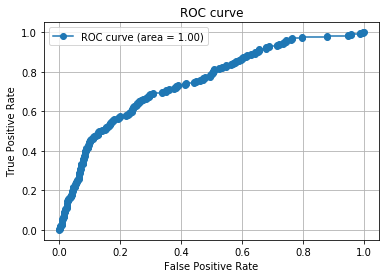

In [27]:
# 検証データ
fpr, tpr, thresholds = roc_curve(y_test, preds)

plt.figure()
plt.plot(fpr, tpr, marker='o', label='ROC curve (area = %.2f)'%auc)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()

roc_auc_score(y_test, preds)

## 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

In [ ]:
df = pd.read_csv('../../home-credit-default-risk/application_train.csv')
test = pd.read_csv('../../home-credit-default-risk/application_test.csv')

SK_ID_CURR = test.iloc[:, 0]

In [ ]:
# 文字列のカテゴリカル変数抽出
objct_cols = df.select_dtypes(include=object)
# display(objct_cols)
objct_cols_list = df.select_dtypes(include=object).columns
# print(objct_cols_list)

# 文字列の列の欠損値を変換
df[objct_cols_list] = df[objct_cols_list].fillna('Missing_Data') 
test[objct_cols_list] = test[objct_cols_list].fillna('Missing_Data') 
# print(df[objct_cols_list].isnull().sum())


# ターゲットエンコーディング
for col in objct_cols_list:
    label_mean = df.groupby(col).TARGET.mean() # groupby()でラベル分した後にラベル毎の'label'の列の平均を取得
    df[col] = df[col].map(label_mean).copy() # df[C]に値を代入
    test[col] = test[col].map(label_mean).copy() # test データにも適用。
# df[objct_cols_list]


# 欠損値処理
df = df.dropna() # 欠損値がある行を削除
test = test.fillna(df.median())
# df = df.fillna(df.mean()) # 欠損値を平均に置き換え
# df = df.fillna(df.median()) # 欠損値を中央値に置き換え

In [ ]:
preds = gbm.predict(test)

In [ ]:
Submission = pd.DataFrame({ 'SK_ID_CURR': SK_ID_CURR,'TARGET': preds })
Submission

In [ ]:
Submission.to_csv("Submission.csv", index=False)

### 【問題5】解答

アイデア
* ターゲットエンコーディング
* LightGBM

スコア
* Private Score：0.69973
* Public Score：0.68933